In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import easydict
from tqdm.notebook import trange, tqdm
import seaborn as sns

In [ ]:
torch.manual_seed(0)

In [ ]:
"""
Data
"""
# 앞의 3개 피쳐만 쓸거면: 3,12 
# 앞의 6개 피쳐만 쓸거면: 6,12 (전류포함)
# 뒤의 6개 피쳐만 쓸거면: 0,6 (vibration만)
# 전체 데이터를 쓸거면: 6,12
feature_num = 6
feature_num2 = 12
strength = 0.2
"""
Mode
"""
# Train or Test
Mode = 'Test'

"""
Model
"""
LSTM_AE = '/content/drive/MyDrive/Colab Notebooks/모델들/LSTM-AE(6feature).pt'


In [ ]:
args = easydict.EasyDict({
    "batch_size": 128, ## 배치 사이즈 설정
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'), ## GPU 사용 여부 설정
    "input_size": 6, ## 입력 차원 설정
    "latent_size2":3, ## Hidden 차원 설정
    "latent_size": 3, ## Hidden 차원 설정
    "output_size": 6, ## 출력 차원 설정
    "window_size" : 100, ## sequence Lenght
    "num_layers": 2,     ## LSTM layer 갯수 설정
    "learning_rate" : 0.01, ## learning rate 설정
    "max_iter" : 20000, ## 총 반복 횟수 설정
    'early_stop' : True,  ## valid loss가 작아지지 않으면 early stop 조건 설정
    "num" : 0, ##window size에서 몇번째 index의 데이터를 활용할지
})

# Data prepare

In [ ]:
def minmax_scaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator+1e-7)

In [ ]:
def Call_data(input_file, feature_num, feature_num2):
  #데이터 파일을 불러옴
  xy=pd.read_table(input_file,sep=',')

  #timestamp를 시간 형식으로 전환
  xy['date'] = pd.to_datetime(xy['timestamp'])
  del xy['timestamp']
  xy = xy.set_index('date')

  #데이터의 feature들의 scale을 맞춰줌.
  train_xy=minmax_scaler(xy)


  #데이터의 앞의 3열만을 불러옴
  for col in train_xy.columns[range(feature_num,feature_num2)]:
      del train_xy[col]

  #데이터 그래프로 확인
  for col in train_xy.columns[:3]:
      plt.plot(train_xy[col],label=col)
  plt.legend()
  plt.show()

  #데이터 확인
  print(train_xy.head())

  return train_xy

In [ ]:
def Split_data(data):
  interval_n = int(len(data)/10)
  train_data = data.iloc[0:interval_n*6] # 학습 데이터
  validate_data = data.iloc[interval_n*6:interval_n*8] # 검증 데이터
  test_data = data.iloc[int(interval_n*8):] # 테스트 데이터

  return train_data, validate_data, test_data

In [ ]:
def Generate_noise(data, ratio, strength):
  interval_n = int(len(data)/10)
  normal_data = data.iloc[0:interval_n*ratio[0]]
  anomal_data = data.iloc[interval_n*ratio[0]:interval_n*ratio[1]]
  normal_data2 = data.iloc[interval_n*ratio[1]:]

  Normal_data = np.array(normal_data)
  Anomal_data = np.array(anomal_data)
  Normal_data2 = np.array(normal_data2)

  noise_matrix = np.random.normal(0,strength,(Anomal_data.shape[1],Anomal_data.shape[1]))
  noise_data = np.dot(Anomal_data,noise_matrix)

  margin_data = np.append(Normal_data,noise_data,axis=0)
  margin_data = np.append(margin_data,Normal_data2,axis=0)

  anomal_idx = range(len(Normal_data),len(Normal_data)+len(Anomal_data))

  x = np.arange(0,len(margin_data),1)

  for i in range(margin_data.shape[1]):
    plt.plot(x,margin_data[:,i],'b')
    plt.show()

  return margin_data, anomal_idx

In [ ]:
def make_data_idx(data, window_size):
  input_idx = []
  for idx in range(window_size-1, len(data)):
    input_idx.append(list(range(idx - window_size+1, idx+1)))

  return input_idx

In [ ]:
# import some packages you need here

class Get_Dataset(Dataset):

    def __init__(self, data, Windowsize):
      
      self.input_ids = make_data_idx(data, Windowsize)

      self.var_data = np.array(data)
      self.var_data = torch.FloatTensor(self.var_data)

    def __len__(self):

        # write your codes here
        return len(self.input_ids)

    def __getitem__(self, idx):
      temp_input_ids = self.input_ids[idx]
      input_values = self.var_data[temp_input_ids]

      return input_values

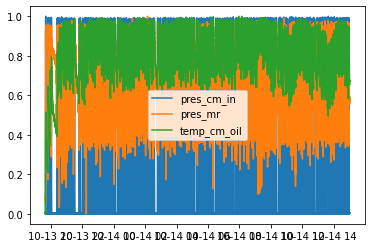

                         pres_cm_in   pres_mr  ...  curr_v  curr_w
date                                           ...                
2020-10-13 19:39:45.010    0.001054  0.072222  ...     0.0     0.0
2020-10-13 19:39:45.130    0.003161  0.066667  ...     0.0     0.0
2020-10-13 19:39:46.340    0.001054  0.066667  ...     0.0     0.0
2020-10-13 19:39:46.440    0.002107  0.072222  ...     0.0     0.0
2020-10-13 19:39:46.550    0.001054  0.061111  ...     0.0     0.0

[5 rows x 6 columns]


In [ ]:
# 앞의 3개 피쳐만 쓸거면: 3,12 
# 앞의 6개 피쳐만 쓸거면: 6,12 (전류포함)
# 뒤의 6개 피쳐만 쓸거면: 0,6 (vibration만)
# 전체 데이터를 쓸거면: 0,0
#텍스트 파일로 저장된 데이터를 불러옴 이때 활용할 feature의 개수를 입력해줌.
train_xy = Call_data('/content/drive/MyDrive/Colab Notebooks/5.txt',feature_num,feature_num2)

In [ ]:
#데이터를 train, validate, test 데이터 3가지로 나눔.
train_data, validate_data, test_data = Split_data(train_xy)

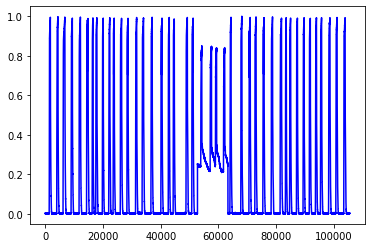

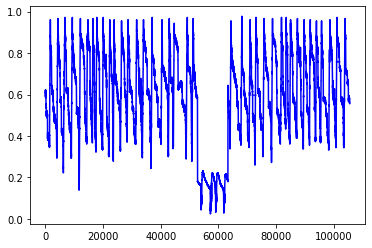

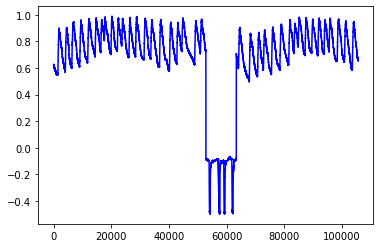

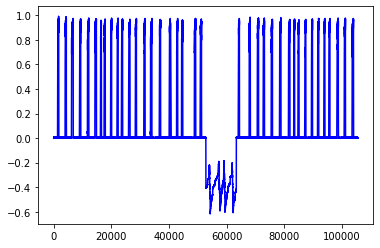

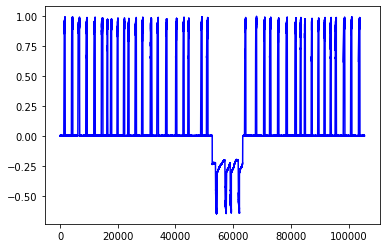

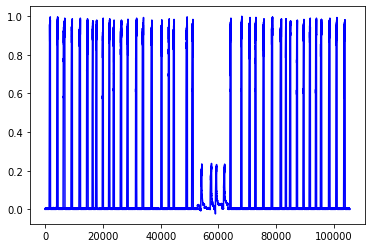

In [ ]:
#Test 데이터에 고의적으로 노이즈를 입힘, 노이즈의 비율과 강도를 조절할 수 있음.
test_data2, anomal_idx = Generate_noise(test_data, [5,6], strength)

In [ ]:
#데이터 셋을 구성함.
train_dataset = Get_Dataset(train_data, args.window_size)
validate_dataset = Get_Dataset(validate_data, args.window_size)
test_dataset = Get_Dataset(test_data2, args.window_size)

In [ ]:
#로더 형태로 변환함
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
valid_loader = torch.utils.data.DataLoader(
                dataset=validate_dataset,
                batch_size=args.batch_size,
                shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

# LSTM-AE

In [ ]:
## 인코더
class Encoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return (hidden, cell)
    
## 디코더
class Decoder(nn.Module):

    def __init__(self, input_size=4096, hidden_size=1024, output_size=4096, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.1, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 window_size: int=1,
                 **kwargs) -> None:
        """
        :param input_dim: 변수 Tag 갯수
        :param latent_dim: 최종 압축할 차원 크기
        :param window_size: 길이
        :param kwargs:
        """

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.window_size = window_size

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss

In [ ]:
def run(args, model, train_loader, test_loader):
    # optimizer 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    ## 반복 횟수 Setting
    epochs = tqdm(range(args.max_iter//len(train_loader)+1))
    
    ## 학습하기
    count = 0
    best_loss = 100000000
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training")

        for i, batch_data in train_iterator:
            
            if count > args.max_iter:
                return model
            count += 1
            
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            loss = model.loss_function(*predict_values)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_iterator.set_postfix({
                "train_loss": float(loss),
            })

        model.eval()
        eval_loss = 0
        test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
        with torch.no_grad():
            for i, batch_data in test_iterator:
                
                batch_data = batch_data.to(args.device)
                predict_values = model(batch_data)
                loss = model.loss_function(*predict_values)

                eval_loss += loss.mean().item()

                test_iterator.set_postfix({
                    "eval_loss": float(loss),
                })
        eval_loss = eval_loss / len(test_loader)
        epochs.set_postfix({
             "Evaluation Score": float(eval_loss),
        })
        if eval_loss < best_loss:
            best_loss = eval_loss
        else:
            if args.early_stop:
                print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
                return model
        
    return model

def get_loss_list(args, model, test_loader, num):
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
    loss_list = []
    predictions = []
    true_data = []
    with torch.no_grad():
        for i, batch_data in test_iterator:
                
            batch_data = batch_data.to(args.device)
            predict_values = model(batch_data)
            
            ## MAE(Mean Absolute Error)로 계산
            loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
            #loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
            loss = loss.mean(dim=1).cpu().numpy()
            for k in range(len(predict_values[0])):
              predictions.append(predict_values[0][k][num])
              true_data.append(predict_values[1][k][num])

            loss_list.append(loss)
    loss_list = np.concatenate(loss_list, axis=0)
    return loss_list,predictions,true_data

In [ ]:
#입력한 args 대로 모델을 구성함.
model = LSTMAutoEncoder(input_dim=args.input_size, latent_dim=args.latent_size, window_size=args.window_size, num_layers=args.num_layers)
model.to(args.device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=3, out_features=6, bias=True)
  )
)

In [ ]:
def compare_plot(predictions, true_data, correct_anomaly, uncorrect_normal, num):
  predict=[]
  true=[]
  correct_anomaly_predict=[]
  uncorrect_normal_predict=[]


  for i in range(len(predictions)):
    predict.append(predictions[i][num])
    true.append(true_data[i][num])
  
  for i in correct_anomaly:
    correct_anomaly_predict.append(predict[i])
  for i in uncorrect_normal:
    uncorrect_normal_predict.append(true[i])

  predict = np.array(predict)
  true = np.array(true)
  correct_anomaly_predict = np.array(correct_anomaly_predict)
  uncorrect_normal_predict = np.array(uncorrect_normal_predict)

  total_x = len(predict)
  x = np.arange(0,total_x,1)

  plt.figure(figsize=(16, 6))
  plt.plot(x,predict,'b',label='predict')
  plt.plot(x,true,'r',label='true')
  plt.plot(correct_anomaly,correct_anomaly_predict,'*g',label='correct_anomaly')
  plt.plot(uncorrect_normal,uncorrect_normal_predict,'ok',label='miss')
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
## Anomaly Score
class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], '평균과 분산의 차원이 똑같아야 합니다.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)


In [ ]:
## anomaly score 얻기
def Get_anomaly_scores(loss_list):

  mean = np.mean(loss_list, axis=0)
  std = np.cov(loss_list.T)

  anomaly_calculator = Anomaly_Calculator(mean, std)

  anomaly_scores = []
  for temp_loss in tqdm(loss_list):

    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)
    
  return anomaly_scores

In [ ]:
def Get_Threshold(valid_loader, test_loader, num):

  ## Validate data의 Reconstruction Error를 구하기
  loss_list_validate,predictions_validate, true_data_validate = get_loss_list(args, model, valid_loader,num)
  ## Test datad의 Reconstruction Error를 구하기
  loss_list_test,predictions_test, true_data_test = get_loss_list(args, model, test_loader,num)

  anomaly_scores_validate = Get_anomaly_scores(loss_list_validate)
  anomaly_scores_test = Get_anomaly_scores(loss_list_test)

  anomaly_scores_validate.sort()

  sns.distplot(anomaly_scores_test, bins=50, kde=True);

  print("Please set THRESHOLD")

  return anomaly_scores_test, predictions_test, true_data_test


In [ ]:
def get_Accuracy(anomaly_scores_test, anomal_idx, THRESHOLD, num):

  anomaly_index_true = range(anomal_idx[0]-(num+1),anomal_idx[-1]-(num+1))
  anomaly_index_predict = []
  correct_anomaly = []
  uncorrect_normal = []
  for i in range(0,len(anomaly_scores_test)):
    if anomaly_scores_test[i] >= THRESHOLD:
      anomaly_index_predict.append(i)

  for i in range(0,len(anomaly_index_predict)):
    k = anomaly_index_predict[i]
    if k in anomaly_index_true:
      correct_anomaly.append(k)
    if k not in anomaly_index_true:
      uncorrect_normal.append(k)


  print(f'Correct anomaly predictions: {len(correct_anomaly)}/{len(anomaly_index_true)}')
  print("Accuracy: {:.2f}%".format(len(correct_anomaly)/len(anomaly_index_true)*100))
  print(f'Miss anomaly predictions: {len(uncorrect_normal)}/{len(anomaly_scores_test)-len(anomaly_index_true)}')
  print("Error: {:.2f}%".format(len(uncorrect_normal)/len(anomaly_scores_test)*100))

  return correct_anomaly, uncorrect_normal

# Result

In [ ]:
## 학습하기
if Mode == 'Train':
  model = run(args, model, train_loader, valid_loader)
  torch.save(model,'/content/drive/MyDrive/Colab Notebooks/LSTM-AE(6feature).pt')


early stop condition   best_loss[0.004681090331907346]  eval_loss[0.004875758129626386]


In [ ]:
#학습한 모델을 불러옴
if Mode == 'Test':
  model = torch.load(LSTM_AE)
  model.eval()

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
  )
  (reconstruct_decoder): Decoder(
    (lstm): LSTM(6, 3, num_layers=2, batch_first=True, dropout=0.1)
    (relu): ReLU()
    (fc): Linear(in_features=3, out_features=6, bias=True)
  )
)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Please set THRESHOLD


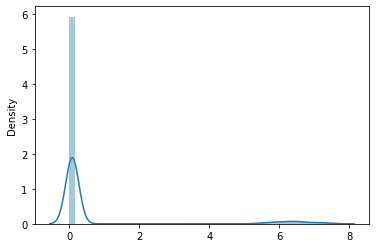

In [ ]:
#Validate 의 displot을 참고하여 Threshold를 튜닝해주어야함.
anomaly_scores_test, predictions_test, true_data_test = Get_Threshold(valid_loader, test_loader, args.num)

In [ ]:
#Threshold를 정해줌
THRESHOLD = 2

In [ ]:
#Test 데이터의 정확도, 에러를 나타냄.
correct_anomaly, uncorrect_normal = get_Accuracy(anomaly_scores_test, anomal_idx,THRESHOLD,0)

Correct anomaly predictions: 10498/10549
Accuracy: 99.52%
Miss anomaly predictions: 42/94855
Error: 0.04%


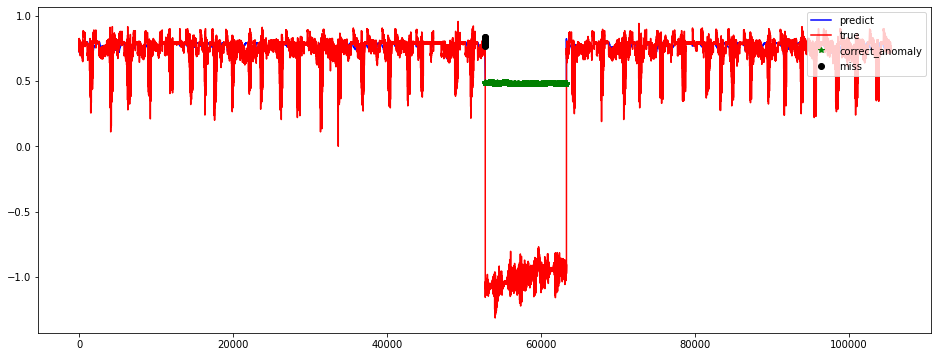

In [ ]:
#Test 데이터를 직접 플롯하고, 이상 데이터를 잘 감지했는지 시각화함.
compare_plot(predictions_test, true_data_test, correct_anomaly, uncorrect_normal, 1)